## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [16]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [17]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [24]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2023-12-18 18:27:17--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.2’

onegin.txt.2        100%[===================>] 256,37K   981KB/s    in 0,3s    

2023-12-18 18:27:18 (981 KB/s) - ‘onegin.txt.2’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [25]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [26]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [27]:
next(generate_chunk())

array([[83, 53, 52, ..., 50,  5,  0],
       [83, 49, 61, ..., 59, 63,  1],
       [83, 64, 51, ..., 66,  5,  0],
       ...,
       [83, 58, 53, ..., 50, 61, 50],
       [83, 49,  1, ..., 59, 69, 56],
       [83, 72, 66, ..., 38,  0,  0]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [41]:
import typing
PAD_IDX = token_to_idx['<sos>']

In [45]:
token_to_idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '(': 3,
 ')': 4,
 ',': 5,
 '-': 6,
 '.': 7,
 '5': 8,
 '7': 9,
 '8': 10,
 '9': 11,
 ':': 12,
 ';': 13,
 '?': 14,
 '[': 15,
 ']': 16,
 '^': 17,
 'a': 18,
 'b': 19,
 'c': 20,
 'd': 21,
 'e': 22,
 'f': 23,
 'g': 24,
 'h': 25,
 'i': 26,
 'k': 27,
 'l': 28,
 'm': 29,
 'n': 30,
 'o': 31,
 'p': 32,
 'q': 33,
 'r': 34,
 's': 35,
 't': 36,
 'u': 37,
 'v': 38,
 'w': 39,
 'x': 40,
 'y': 41,
 'z': 42,
 '«': 43,
 '»': 44,
 'а': 45,
 'б': 46,
 'в': 47,
 'г': 48,
 'д': 49,
 'е': 50,
 'ж': 51,
 'з': 52,
 'и': 53,
 'й': 54,
 'к': 55,
 'л': 56,
 'м': 57,
 'н': 58,
 'о': 59,
 'п': 60,
 'р': 61,
 'с': 62,
 'т': 63,
 'у': 64,
 'ф': 65,
 'х': 66,
 'ц': 67,
 'ч': 68,
 'ш': 69,
 'щ': 70,
 'ъ': 71,
 'ы': 72,
 'ь': 73,
 'э': 74,
 'ю': 75,
 'я': 76,
 'ё': 77,
 '–': 78,
 '—': 79,
 '’': 80,
 '…': 81,
 '€': 82,
 '<sos>': 83}

In [42]:
# Перевод токена в буквы
def word_from_tokens(tokens: str) -> np.array:
     return np.array([token_to_idx[token] for token in tokens])

# Перевод уже в предложения 
def sentectence_to_tokens(batch: typing.List[str]) -> np.array:
    return np.concatenate(list(map(word_from_tokens, batch)))

In [46]:
# Сводим (сжимаем/растягиваем) к единому размеру
def shape_text(text: typing.List[str], max_tokens_len: int):
    joined_text = " ".join(text)
    n_tokens = len(joined_text) // max_tokens_len
    reshaped_text = []
    for i in range(0, n_tokens * max_tokens_len, max_tokens_len):
        reshaped_text.append(joined_text[i:i+max_tokens_len])
    return reshaped_text

In [47]:
# Переводим предложения в матрицы для RNN
def to_matrix(text: typing.List[str], max_len: int=None, pad: int=PAD_IDX, dtype: str='int32', batch_first: bool=True):
    size = max_len or max(map(len, text))
    matrix = np.zeros([len(text), size], dtype) + pad
    for i in range(len(text)):
        line_ix = sentectence_to_tokens([text[i]])
        matrix[i, :len(line_ix)] = line_ix
    if not batch_first:
        matrix = np.transpose(matrix)
    return torch.tensor(matrix, dtype=torch.int64)

In [48]:
# Из семинара
class VanillaCharRNN(nn.Module):
   
    def __init__(
        self,
        num_tokens: int=len(tokens),
        embedding_size: int=64,
        rnn_num_units: int=128
    ):
        super(VanillaCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        out, h_next = self.rnn(x_emb, h_prev)
        logits = self.linear(out)
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)

In [13]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import clear_output
import seaborn as sns
sns.set_theme(style='darkgrid')

class CharRNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, hidden_size=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True,
                         nonlinearity='relu')
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)
        self.hidden_size = hidden_size
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        out, hid_state = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(out)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
    def generate(self, x, hid_state):
        out, hid_state = self.rnn(self.emb(x), hid_state)
        next_logits = self.hid_to_logits(out)
        return next_logits, hid_state

In [14]:
loss_history = []

try:
    del model
except:
    pass 

model = CharRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                milestones=[1500, 2500], gamma=0.1)

for i in range(3500):
    batch_ix = to_matrix(sample(quatrains, 16), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)

    loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1), 
                      ignore_index=token_to_idx['_'])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.data.numpy())
    if (i+1)%100 == 0:
        plt.figure(figsize=(10,8))
        clear_output(True)
        plt.plot(loss_history, lw=2, label='loss')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(shadow=True, fontsize=18)
        plt.show()

NameError: name 'to_matrix' is not defined

In [49]:
def rnn_epoch(model, hidden_state, all_batches, batch_size):
    global PAD_IDX
    n_batches = all_batches.shape[0] // batch_size
    loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    epoch_loss = 0.0

    for i in range(0, n_batches * batch_size, batch_size):
        batch_ix = all_batches[i:i+batch_size]
        hidden_state, out = model(batch_ix, hidden_state)
        actual_next_tokens = batch_ix[:, 1:]

        batch_loss = loss(out[:, :-1].reshape(-1, len(tokens)), actual_next_tokens.reshape(-1))
        batch_loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += batch_loss.item()
        hidden_state.detach_()
        hidden_state = hidden_state.detach()

    epoch_loss /= n_batches
    return hidden_state, epoch_loss

In [50]:
def train(model: nn.Module, n_epochs: int=16, optimizer=None, max_tokens_len: int=200-3, batch_size: int=10):
    losses = []
    # Привели к единому размеру
    shaped_text = shape_text(text, max_tokens_len)
    # Перевели в матрицу
    all_batches = to_matrix(shaped_text, max_tokens_len)
    # Поехали
    state = model.initial_state(batch_size)

    for epoch in range(n_epochs):
        print("{}-st epoch of {}".format(epoch + 1, n_epochs))
        state, epoch_loss = rnn_epoch(model, state, all_batches, batch_size)
        losses.append(epoch_loss)

    return losses, state

In [51]:
model = VanillaCharRNN()
optimizer = torch.optim.Adam(model.parameters())
N_EPOCHS = 512
vanilla_losses, vanilla_state = train(model, N_EPOCHS, optimizer)


1-st epoch of 512
2-st epoch of 512
3-st epoch of 512
4-st epoch of 512
5-st epoch of 512
6-st epoch of 512
7-st epoch of 512
8-st epoch of 512
9-st epoch of 512
10-st epoch of 512
11-st epoch of 512
12-st epoch of 512
13-st epoch of 512
14-st epoch of 512
15-st epoch of 512
16-st epoch of 512
17-st epoch of 512
18-st epoch of 512
19-st epoch of 512
20-st epoch of 512
21-st epoch of 512
22-st epoch of 512


KeyboardInterrupt: 

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

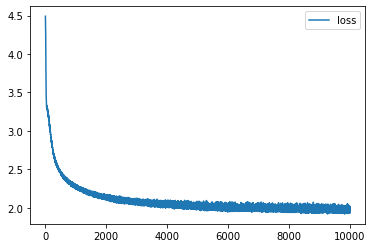

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [12]:
def generate_sample(model, seed_phrase=' ', max_length=400, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    states = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        states, _ = model(x_sequence[:, :, i], states)

    for _ in range(max_length - len(seed_phrase)):
        states, out = model(x_sequence[:,:, -1], states)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0].ravel()
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [ ]:
for t in [0.2, 0.5, 1.0,]:
    print(f"\n\tTemperature: {t}")
    print(generate_sample(model, seed_phrase=" мой дядя самых честных правил", temperature=t))

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [24]:
seed_phrase = ' мой дядя самых честных правил'

In [25]:
# generated_phrases = # your code here

# For example:

generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

На этом задание завершено. Поздравляем!